Let's import the required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
pd.options.display.max_columns = 90

In [2]:
os.listdir("../../DataSet/ds_data_big")

['data_test.csv', 'data_train.csv', 'EN-454459393-170918-0443.pdf', 'readme']

***Reading train and test data in chunks, will read 50k records for each chunk and merge all at the end***

In [3]:
data = pd.read_csv("../../DataSet/ds_data_big/data_train.csv",chunksize=50000)

In [4]:
test_data = pd.read_csv("../../DataSet/ds_data_big/data_test.csv", chunksize=50000)

Converting the categorical columns to category datatype

In [5]:
def check_and_convert(data, data_type):
    for n_cat in range(1,15,1):
        #filling the nulls with most common value in the column (only for categorical columns)
        data['cat'+str(n_cat)] = data['cat'+str(n_cat)].fillna(data['cat'+str(n_cat)].value_counts().index[0])
        if sum(data['cat'+str(n_cat)] - data['cat'+str(n_cat)].astype(np.uint8)) != 0:
            print("Column cat"+str(n_cat)+" has more decimal point greater than 0")
        else:
            data['cat'+str(n_cat)] = data['cat'+str(n_cat)].astype(np.uint8).astype(data_type)
    return data

**Trying to reduce the dataset size as my system has less memory**

In [6]:
def check_and_reduce(data, col_range_start, col_range_end):
    for col in data.iloc[:,col_range_start:col_range_end].columns:
        mn = data[col].min()
        mx = data[col].max()
        ItsInt = False

        #print(col, "Min: ",mn,"  Max: ",mx)

        convint = data[col].fillna(0).astype(np.int64)
        res = (data[col] - convint)
        res = res.sum()

        if res > -0.01 and res < 0.01:
            ItsInt = True

        if ItsInt:
            #print("Validating")
            if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                #print(col, "8")
                data[col] = data[col].astype(np.int8)
            elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                #print(col, "16")
                data[col] = data[col].astype(np.int16)
            elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                #print(col , "32")
                data[col] = data[col].astype(np.int32)
            elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                #print(col, "64")
                data[col] = data[col].astype(np.int64)
        elif data[col].dtype!=object:
            data[col] = data[col].astype(np.float32)
    return data

So here will read train data and for every chunk perform the following operations:<br/>
<ul>
    <li>Call <b>check_and_convert</b> to convert categorical variables to category data type</li> 
    <li>Reduce the DataFrame memory usage by converting the columns to appropriate datatypes (done by <b>check_and_reduce</b> function)</li>
</ul>

In [7]:
num_chunks = 0
before = 0
after = 0
df_full = pd.DataFrame()
df_chunk = pd.DataFrame()
for chunks in data:
    num_chunks +=1
    df_chunk = pd.concat([df_chunk, chunks])
    print(df_chunk.shape)
    df_chunk= check_and_convert(df_chunk, 'category')
    
    #Lets fill null columns with medium value
    for col in df_chunk.iloc[:,1:43].columns:
        df_chunk[col] = df_chunk[col].fillna(df_chunk[col].median())
        
    mem_size = df_chunk.memory_usage().sum() / ((1024)**2)
    before += mem_size
    
    df_chunk = check_and_reduce(df_chunk, 0, 43)
    mem_size = df_chunk.memory_usage().sum() / ((1024)**2)
    after += mem_size
    
    df_full = pd.concat([df_full,df_chunk])

(50000, 58)
(100000, 58)
(150000, 58)
(200000, 58)
(250000, 58)
(300000, 58)
(350000, 58)
(400000, 58)
(450000, 58)
(500000, 58)
(550000, 58)
(596000, 58)


In [8]:
#before = df_chunk.memory_usage().sum() / ((1024)**2)
print("Memory usage for original df: "+str(before) + " MB")

Memory usage for original df: 1389.7056579589844 MB


In [9]:
#after = df_chunk.memory_usage().sum() / ((1024)**2)
print("Memory usage after reducing df: "+str(after) + " MB")

Memory usage after reducing df: 393.9476013183594 MB


In [10]:
( 1- (after / before))* 100
#Woooaa, dataframe memory is reduced by 71%, I hope my model training will be faster now.

71.65244315857953

In [11]:
df_full.columns

Index(['id', 'num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8',
       'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16',
       'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'der1',
       'der2', 'der3', 'der4', 'der5', 'der6', 'der7', 'der8', 'der9', 'der10',
       'der11', 'der12', 'der13', 'der14', 'der15', 'der16', 'der17', 'der18',
       'der19', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'target'],
      dtype='object')

In [12]:
df_full.dtypes.to_frame().T

,id,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,num22,num23,der1,der2,der3,der4,der5,der6,der7,der8,der9,der10,der11,der12,der13,der14,der15,der16,der17,der18,der19,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,target
0,int32,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,float32,float32,float32,int8,float32,float32,float32,float32,float32,float32,float32,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,category,category,category,category,category,category,category,category,category,category,category,category,category,category,int64


Let's take label and feature in different variables

In [13]:
targets = df_full.target

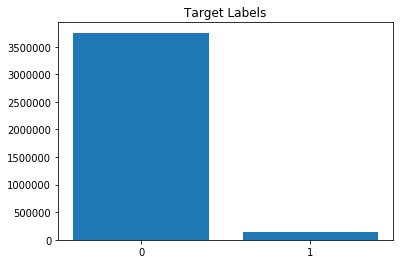

In [53]:
plt.bar(targets.value_counts().index,targets.value_counts().values)
plt.xticks([0,1])
plt.title("Target Labels")
plt.show()

In [14]:
#dropping id and target column. cat6 and cat8 have lot of null values so lets drop them as they won't add much value
features = df_full.drop(['id','target','cat6', 'cat8'], axis=1)

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

c:\installedsoftwares\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**Well, here I will fit our training data on different algorithms and compare accuracy scroe.** I will be using classification following algorithms
<br/>Logistic Regression
<br/>Random Forest
<br/>Naive Bayes

In [16]:
models = []
models.append(('Logistic_Regression', LogisticRegression()))
models.append(('Random_Forest', RandomForestClassifier()))
models.append(('Naive_Bayes', GaussianNB()))

In [20]:
cv = KFold(n_splits=12, random_state=1)
scores = []
names = []
for name, model in models:
    score = cross_val_score(model, features, targets, cv=cv, scoring='accuracy')
    print(name, " : ", score.mean())
    scores.append(score.mean()) 
    names.append(name) 

Logistic_Regression  :  0.9635195072413311
Random_Forest  :  0.9993249472791524
Naive_Bayes  :  0.9033675560855934


**oh.! accuracy score for Random Forest is awesome**
<br/>
<br/>But let's make our model less complicated by choosing important features
<br/>So I will use RFE(Recursive Feature Elimination) to choose important features
<br/>I will select top 40 features and fit them Random Forest and Logistic Regression algorithms

In [16]:
lr_model = LogisticRegression()
model = RandomForestClassifier()

In [17]:
selector = RFE(lr_model, 40, step=1)

In [18]:
selector = selector.fit(features, targets)

In [19]:
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True, False])

In [28]:
selector.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 14,  6,  2, 11, 12,  8, 10,
        1,  9,  5,  1,  3,  1,  1,  1,  1,  1,  1,  4,  1, 13,  7,  1,  1,
        1,  1, 15])

In [21]:
len(selector.ranking_)

54

In [25]:
ranks = pd.DataFrame({'Columns':features.columns,'Rank':selector.ranking_})

In [31]:
rank_cols = ranks[ranks['Rank']==1]

In [32]:
rank_cols.reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,34,37,39,40,41,42,43,44,46,49,50,51,52
Columns,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,num22,num23,der1,der2,der3,der4,der12,der15,der17,der18,der19,cat1,cat2,cat3,cat5,cat10,cat11,cat12,cat13
Rank,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [25]:
trainx, testx, trainy, testy = train_test_split(features[rank_cols.Columns], targets, test_size=0.2, random_state=1)

In [27]:
cv = KFold(n_splits=10)

In [29]:
for train_indx, test_indx in cv.split(features, targets):
    lr_model.fit(features.values[train_indx],targets.values[train_indx])
    pred = lr_model.predict(features.values[test_indx])
    print("Logistic Regression: ", accuracy_score(targets.values[test_indx], pred))
    model.fit(features.values[train_indx],targets.values[train_indx])
    pred_rf = model.predict(features.values[test_indx])
    print("Random Forest: ", accuracy_score(targets.values[test_indx], pred_rf))

Logistic Regression:  0.9633136550308008
Random Forest:  1.0
Logistic Regression:  0.9634240246406571
Random Forest:  1.0
Logistic Regression:  0.9634933264887063
Random Forest:  1.0
Logistic Regression:  0.9634779260780287
Random Forest:  1.0
Logistic Regression:  0.9636575975359343
Random Forest:  1.0
Logistic Regression:  0.9635164271047227
Random Forest:  1.0
Logistic Regression:  0.9636498973305955
Random Forest:  0.9999897330595483
Logistic Regression:  0.9636216632443532
Random Forest:  0.9999897330595483
Logistic Regression:  0.9634573921971252
Random Forest:  0.9987910677618069
Logistic Regression:  0.9635831622176592
Random Forest:  0.9945225872689938


Will fit Random Forest model on whole data, before that let me read test dataset and preprocess it as we did with train data

In [33]:
num_chunks = 0
before = 0
after = 0
df_full = pd.DataFrame()
df_chunk = pd.DataFrame()
for chunks in test_data:
    num_chunks +=1
    df_chunk = pd.concat([df_chunk, chunks])
    print(df_chunk.shape)
    df_chunk= check_and_convert(df_chunk, 'category')
    
    #Lets fill null columns with medium value
    for col in df_chunk.iloc[:,1:43].columns:
        df_chunk[col] = df_chunk[col].fillna(df_chunk[col].median())
        
    mem_size = df_chunk.memory_usage().sum() / ((1024)**2)
    before += mem_size
    
    df_chunk = check_and_reduce(df_chunk, 0, 43)
    mem_size = df_chunk.memory_usage().sum() / ((1024)**2)
    after += mem_size
    
    df_full = pd.concat([df_full,df_chunk])

(50000, 57)
(100000, 57)
(150000, 57)
(200000, 57)
(250000, 57)
(300000, 57)
(350000, 57)
(400000, 57)
(450000, 57)
(500000, 57)
(550000, 57)
(600000, 57)
(650000, 57)
(700000, 57)
(750000, 57)
(800000, 57)
(850000, 57)
(892816, 57)


Fit the model and predict for test data

In [36]:
#Printing the memory usage
print("Before: "+str(before)+"MB, After: "+str(after)+"MB, Percentage Reduced: "+str(( 1- (after / before)) * 100)+"%")

Before: 2981.979995727539MB, After: 798.5667877197266MB, Percentage Reduced: 73.22025000624146%


In [38]:
test_features = df_full.drop(['id','cat6', 'cat8'], axis=1)

In [34]:
model.fit(features[rank_cols.Columns], targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [40]:
pred = model.predict(test_features[rank_cols.Columns])

In [41]:
results = pd.DataFrame()
results['id'] = df_full.id
results['target'] = pred

In [42]:
#Exporting the results to csv
results.to_csv("results.cvs", index=False)
#features.var().sort_values()
#round(df_full.corr(),2)

**So above is the simple way that could be achived for this dataset, further we can improve it by performing more statistical analysis by using following steps:**<br/>
Check Variance of the features and drop the features with least variance as they don't contribute much to the target value<br/>
Calculate correlation between features and targets, run hypothesis test such as Chi-Square test, then we can go ahead choose the important features only<br/>
As we have lot of features here we can run PCA and reduce down the number of columns to make training time shorter and memory efficient<br/>

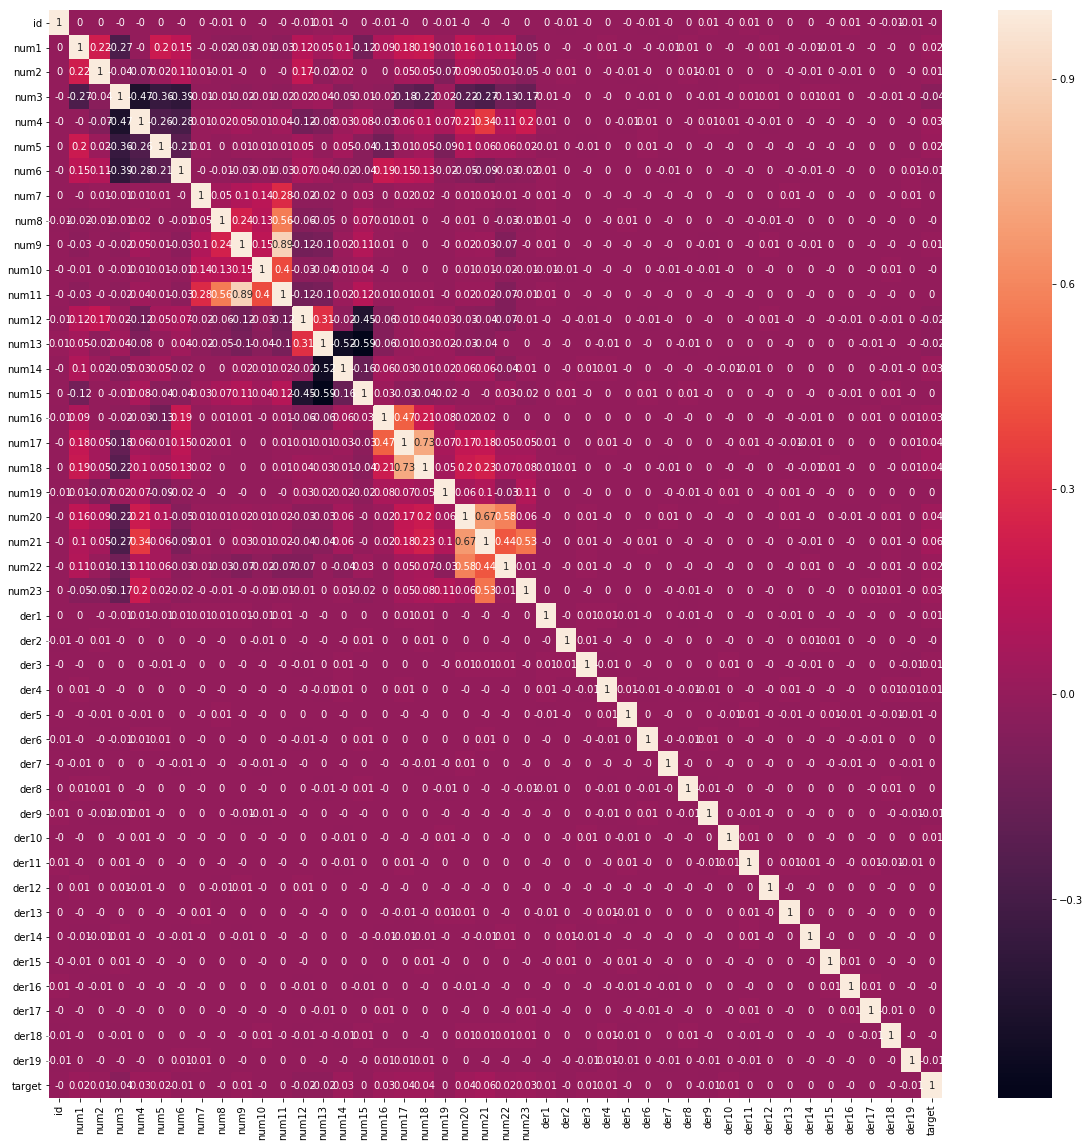

In [52]:
fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(round(df_chunk.corr(),2), ax=ax, annot=True)